In [2]:
import os, re
from dotenv import dotenv_values

from sqlalchemy import create_engine, text

from datetime import date,datetime,timedelta
import pandas as pd
import numpy as np

from tensorflow import keras

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patches as patches

import requests

## API and SQL configuration

In [3]:
# Settings from .env file

settings = dotenv_values()

# SQL CONFIG

settings = dotenv_values() # Loads settings from .env file
ROOT='..' # relative path to the root of the project

db_uri = (
    f"mysql+pymysql://{settings['SQL_USER']}:{settings['SQL_PWD']}"
    f"@{settings['SQL_HOST']}/{settings['SQL_DB']}"
    f"?ssl_ca={os.path.join(ROOT,settings['SQL_SSL_CA'])}"
    f"&ssl_cert={os.path.join(ROOT,settings['SQL_SSL_CERT'])}"
    f"&ssl_key={os.path.join(ROOT,settings['SQL_SSL_KEY'])}"
    f"&ssl_check_hostname=false"
)

engine = create_engine(db_uri,echo=False, future=False)

# WeatherAPI CONFIG

url = 'http://api.weatherapi.com/v1/forecast.json'
key = settings['WA_KEY']

## Test configuration (dates, station_id)

In [4]:
# Test Station ID
station_id = 6000990

# list of the 60 days before today (for History data)
history_days = pd.date_range(date.today() - timedelta(60),periods=60)

# list of today + 9 following days (for Forecast data)
forecast_days = pd.date_range(date.today(),periods=10)
forecast_days

# all days
days = pd.date_range(date.today() - timedelta(60),periods=70)

## Data Loading (Weather History an Forecast, Station info)

In [5]:
# station dataframe (from Cloud SQL)

query = "SELECT * FROM stations ;"
stations = pd.read_sql_query(query,engine)
stations.set_index('station_id',inplace=True,drop=True)
stations.head()

,label,alt,river_id,river_label,mean_nitrate,lat,lon
station_id,,,,,,,
6000990,BELRUPT,292,U---0000,La Saône,4.513699,48.090273,6.101941
6000993,JONVELLE,230,U---0000,La Saône,9.433333,47.936380,5.923536
6000998,MONTHUREUX-SUR-SAONE 2,241,U---0000,La Saône,6.428571,48.018251,5.941492
6001000,CENDRECOURT,213,U---0000,La Saône,9.233333,47.840261,5.917378
6002500,PORT-SUR-SAONE,208,U---0000,La Saône,7.489474,47.691078,6.039292


In [6]:
# Weather History dataframe (weather history, from Cloud SQL)

query = """
SELECT day, station_id, temperature, precipitation, maxwind
FROM weather
WHERE station_id = {}
AND day BETWEEN '{}' AND '{}' ;
"""

# We can use str.format() here, injection safe, pd.read_sql_query() used
f_query = query.format(
    station_id,
    history_days[0].strftime('%Y-%m-%d'),
    history_days[-1].strftime('%Y-%m-%d')
)

history_weather = pd.read_sql_query(f_query,engine)
history_weather.day = pd.to_datetime(history_weather.day)
history_weather.head()


,day,station_id,temperature,precipitation,maxwind
0,2021-12-16,6000990,4.7,0.0,10.8
1,2021-12-17,6000990,3.7,0.0,10.8
2,2021-12-18,6000990,4.5,0.0,14.8
3,2021-12-19,6000990,3.6,0.0,9.0
4,2021-12-20,6000990,3.2,0.0,14.8


In [7]:
# Weather Forecast dataframe (weather forecast, from WeatherAPI.com API)

gps_coord = f"{stations.loc[station_id,'lat']},{stations.loc[station_id,'lon']}"

params = {
    'key':key,
    'q':gps_coord,
    'days':10,
}

response = requests.get(url,params)
json_resp = response.json()
forecast_days = json_resp.get('forecast').get('forecastday')

# Tests
assert response                                                               # response in 2XX and 3XX
assert len(forecast_days) == 10                                               # 10 days in the response
assert forecast_days[0].get('date') == datetime.today().strftime('%Y-%m-%d')  # First day is today


list_forecast = {
    'day':[],
    'temperature':[],
    'precipitation':[],
    'maxwind':[]
}

for day in forecast_days :
    
    str_date = datetime.strptime(day.get('date'),'%Y-%m-%d')
    list_forecast['day'].append(str_date)
    
    temperature = day.get('day').get('avgtemp_c')
    list_forecast['temperature'].append(temperature)
    
    maxwind = day.get('day').get('maxwind_kph')
    list_forecast['maxwind'].append(maxwind)
    
    precipitation = day.get('day').get('totalprecip_mm')
    list_forecast['precipitation'].append(precipitation)
    
forecast_weather = pd.DataFrame(list_forecast)
forecast_weather['station_id'] = station_id
forecast_weather.head()

# Tests
assert len(forecast_weather) == 10
assert type(forecast_weather.loc[0,'day']) == pd._libs.tslibs.timestamps.Timestamp
assert not forecast_weather.isna().sum().sum() # No NA values

In [8]:
# Final weather dataframe (history + forecast)

weather = pd.concat([history_weather,forecast_weather])

# Tests
assert len(weather) == 70
assert list(weather.columns) == \
['day', 'station_id', 'temperature', 'precipitation','maxwind']
assert not weather.isna().sum().sum() # No NA values

## Data Constitution

In [9]:
# First, adding days
data = pd.DataFrame(days,columns=['day'])

# Adding mean_nitrate
data['mean_nitrate'] = stations.loc[station_id,'mean_nitrate']

# Adding weather
data = pd.merge(data,weather,on='day',how='left')

# Adding previous temperatures, maxwinds and precipitations
DELTA = 60

for delta in range(1,DELTA+1):
    data[f'maxwind_{delta}'] = data['maxwind'].shift(periods=delta)
    data[f'temperature_{delta}'] = data['temperature'].shift(periods=delta)
    data[f'precipitation_{delta}'] = data['precipitation'].shift(periods=delta)
    data = data.copy()
    
data.dropna(inplace=True)

# Adding day_of_year columns
data['doy'] = data['day'].dt.dayofyear # doy = day of year

# Turns day of year to cyclical feature (sin,cos)
data['sin_doy'] = np.sin( (data['doy']-1) * 2 * np.pi / 365 )
data['cos_doy'] = np.cos( (data['doy']-1) * 2 * np.pi / 365 )

# Tests
assert len(data) == 10
assert not data.isna().sum().sum()

data.head()

,day,mean_nitrate,station_id,temperature,precipitation,maxwind,maxwind_1,temperature_1,precipitation_1,maxwind_2,...,precipitation_58,maxwind_59,temperature_59,precipitation_59,maxwind_60,temperature_60,precipitation_60,doy,sin_doy,cos_doy
60,2022-02-14,4.513699,6000990,6.7,3.6,27.7,28.4,5.6,0.0,7.2,...,0.0,10.8,3.7,0.0,10.8,4.7,0.0,45,0.687053,0.726608
61,2022-02-15,4.513699,6000990,4.7,0.9,23.4,27.7,6.7,3.6,28.4,...,0.0,14.8,4.5,0.0,10.8,3.7,0.0,46,0.699458,0.714673
62,2022-02-16,4.513699,6000990,5.5,20.2,29.2,23.4,4.7,0.9,27.7,...,0.0,9.0,3.6,0.0,14.8,4.5,0.0,47,0.711657,0.702527
63,2022-02-17,4.513699,6000990,8.5,11.0,26.3,29.2,5.5,20.2,23.4,...,0.0,14.8,3.2,0.0,9.0,3.6,0.0,48,0.723644,0.690173
64,2022-02-18,4.513699,6000990,7.6,0.3,21.6,26.3,8.5,11.0,29.2,...,0.0,7.2,0.4,0.0,14.8,3.2,0.0,49,0.735417,0.677615


## Predicition with the Keras Model

In [16]:
model = keras.models.load_model('../keras_model')

In [17]:
feature_columns = [
    'sin_doy',
    'cos_doy',
    'mean_nitrate',
    'temperature',
    'precipitation',
    'maxwind',
]

for delta in range(1,DELTA+1) :
    feature_columns += [f'precipitation_{delta}']
    feature_columns += [f'temperature_{delta}']
    feature_columns += [f'maxwind_{delta}']

In [18]:
X = data[feature_columns]
data['prediction'] = model.predict(X)

## Plotting Prediction

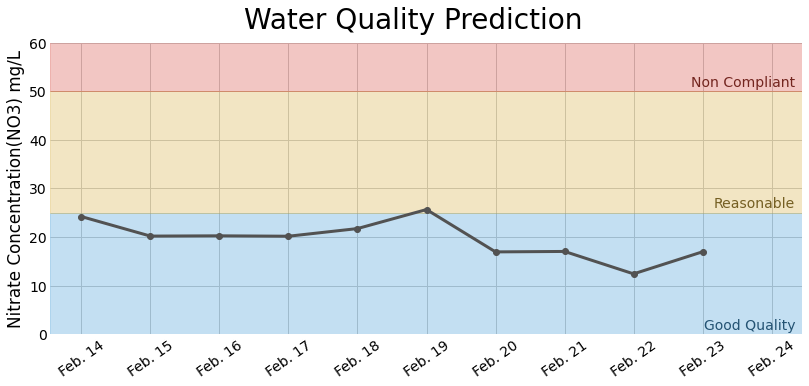

In [45]:
with plt.style.context('fivethirtyeight'):
    
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Water Quality Prediction', fontsize=28)
    fig.patch.set_facecolor('#FFFFFF')
    ax = plt.gca()
    
    plt.plot(data['day'],data['prediction'],marker='o',linewidth=3,color='#525252')
    plt.ylim(bottom=0,top=60)
    plt.xticks(rotation=35)
    ax.set_ylabel('Nitrate Concentration(NO3) mg/L')
    
    # Extending the right part of the graph
    left, right = plt.xlim()
    plt.xlim(left,right + 0.1 * (right - left))
    left, right = plt.xlim()
    
    # 0 -> 25
    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    rect = patches.Rectangle((x0,0), x1-x0,25, linewidth=1, edgecolor='#3B97D4', facecolor='#3B97D4',alpha=0.3)
    ax.add_patch(rect)
    
    ax.text(x=right - 0.1,y=1,s='Good Quality',ha='right',color='#245373')
    
    # 25 -> 50
    rect = patches.Rectangle((x0,25), x1-x0,25, linewidth=1, edgecolor='#D4AB3A', facecolor='#D4AB3A',alpha=0.3)
    ax.add_patch(rect)
    
    ax.text(x=right - 0.1,y=26,s='Reasonable',ha='right',color='#755f23')
    
    # 50 -> 200
    rect = patches.Rectangle((x0,50), x1-x0,150, linewidth=1, edgecolor='#D4453A', facecolor='#D4453A',alpha=0.3)
    ax.add_patch(rect)
    
    ax.text(x=right - 0.1,y=51,s='Non Compliant',ha='right',color='#73251f')
    
    # Date format
    fmt = mdates.DateFormatter('%b. %d')
    ax.xaxis.set_major_formatter(fmt)
    
    # Background and borders
    fig.patch.set_facecolor('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    for location in ['left','right','bottom','top']:
        ax.spines[location].set_visible(False)
    
    plt.show()

In [23]:
left

19036.55

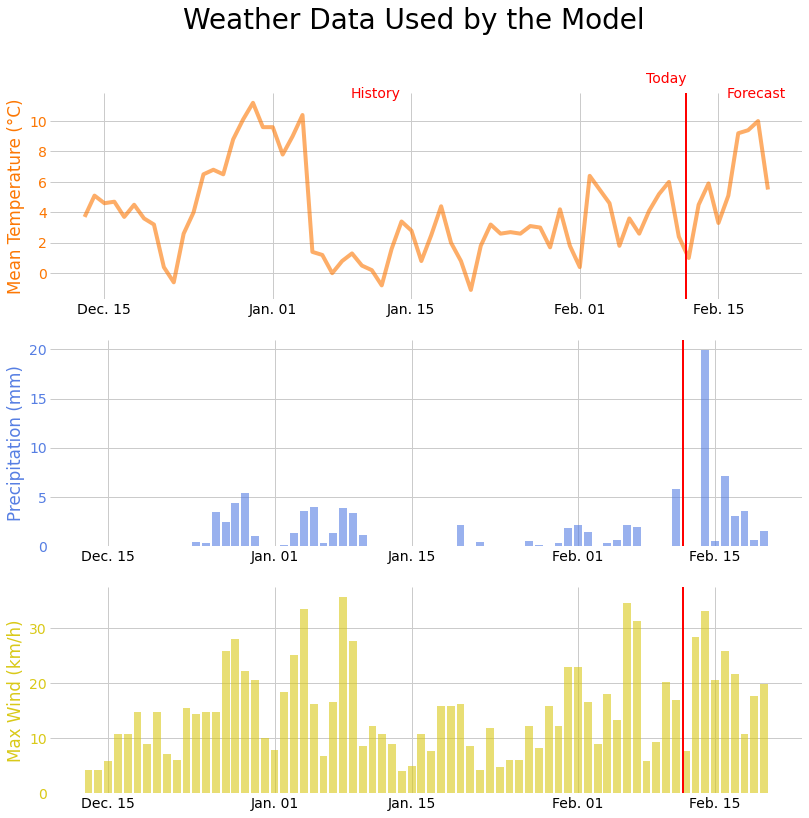

In [253]:
with plt.style.context('fivethirtyeight'):
    
    fig, axs = plt.subplots(3,1,figsize=(12,12))
    fig.suptitle('Weather Data Used by the Model', fontsize=28)
    fig.patch.set_facecolor('#FFFFFF')
    
    # Temperature Plot
    axs[0].plot(weather.day,weather.temperature,color='#fc7703',alpha=0.6)
    axs[0].yaxis.set_tick_params(colors='#fc7703')
    axs[0].set_ylabel('Mean Temperature (°C)',color='#fc7703')
    
    # Today line
    axs[0].axvline(x=datetime.today(),color='red',linewidth=2)
    
    # Today txt
    ylim = axs[0].get_ylim()
    td_y = ylim[0] + (ylim[1] - ylim[0]) * 1.05
    axs[0].text(x=datetime.today()-timedelta(4),y=td_y,s='Today',color='red')
    
    # Forecast txt
    xlim = axs[0].get_xlim()
    f_x = xlim[0] + (xlim[1] - xlim[0]) * 0.9
    fh_y = ylim[0] + (ylim[1] - ylim[0]) * 0.98
    axs[0].text(x=f_x,y=fh_y,s='Forecast',color='red')
    
    # History txt
    h_x = xlim[0] + (xlim[1] - xlim[0]) * 0.4
    axs[0].text(x=h_x,y=fh_y,s='History',color='red')
    

    # Precipitation Plot
    axs[1].bar(weather.day,weather.precipitation,color='#567ee3',alpha=0.6)
    axs[1].yaxis.set_tick_params(colors='#567ee3')
    axs[1].set_ylabel('Precipitation (mm)',color='#567ee3')
    axs[1].axvline(x=datetime.today(),color='red',linewidth=2)
    

    # Maxwind Plot
    axs[2].bar(weather.day,weather.maxwind,color='#d9c918',alpha=0.6)
    axs[2].yaxis.set_tick_params(colors='#d9c918')
    axs[2].set_ylabel('Max Wind (km/h)',color='#d9c918')
    axs[2].axvline(x=datetime.today(),color='red',linewidth=2)
    
    # Background and borders
    for ax in axs :
        ax.patch.set_facecolor('#FFFFFF') # background color to white
        for location in ['left','right','bottom','top']:
            ax.spines[location].set_visible(False)
    
    # Date format
    for ax in axs :
        fmt = mdates.DateFormatter('%b. %d')
        ax.xaxis.set_major_formatter(fmt)
    
    plt.show()